In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
import requests
import io
import os
import pyarrow
from data_processing import load_data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score, silhouette_samples, jaccard_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split

In [16]:
books_clean = pd.read_csv("books_clean.csv")

In [18]:
books_clean = books_clean.rename(columns={'Unnamed: 0': 'book_id'})

In [19]:
books_clean.head()

,book_id,text_reviews_count,average_rating,num_pages,publication_year,ratings_count,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
0,5333265,1,4.00,256,1984,3,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0
1,1333909,6,3.23,256,2001,10,0.022321,0.977679,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0
2,7327624,7,4.03,600,1987,140,0.000000,0.195122,0.756098,0.024390,0.02439,0.000000,0.0,0.0,0.0,0.0
3,6066819,3282,3.49,368,2009,51184,0.000000,0.943878,0.000000,0.017007,0.00000,0.039116,0.0,0.0,0.0,0.0
4,287140,5,3.40,256,2011,15,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.0,0.0,0.0


In [32]:
scaler = StandardScaler()
normalizer = Normalizer()

In [103]:
books_clean = books_clean[books_clean['ratings_count'] > 1500]   

In [104]:
books_clean.shape

(64693, 16)

In [105]:
normalized_df = normalizer.fit_transform(books_clean)
scaled_df = scaler.fit_transform(books_clean)

In [106]:
def perform_pca(dataframe, name, n_components=None):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataframe)
    pca = PCA(n_components=n_components, random_state=41)
    pca_components = pca.fit_transform(df_scaled)

    pca_df = pd.DataFrame(pca_components)
    pca_df.to_csv(f'{name}_pca_components2.csv', index=False)

    info_df = pd.DataFrame({
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'singular_values': pca.singular_values_
    })
    info_df.to_csv(f'{name}_pca_info2.csv', index=False)


def perform_svd(dataframe, name):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(dataframe)
    u, s, vt = svds(csr_matrix(df_scaled))

    u_df = pd.DataFrame(u)
    u_df.to_csv(f'{name}_svd_U2.csv', index=False)

    v_df = pd.DataFrame(vt.T)
    v_df.to_csv(f'{name}_svd_V2.csv', index=False)

    s_df = pd.DataFrame(s)
    s_df.to_csv(f'{name}_svd_S2.csv', index=False)


def perform_nmf(dataframe, name, n_components='auto'):
    nmf = NMF(n_components=n_components, init='random', random_state=41)
    nmf_components = nmf.fit_transform(csr_matrix(dataframe))

    nmf_df = pd.DataFrame(nmf_components)
    nmf_df.to_csv(f'{name}_nmf_components2.csv', index=False)

In [107]:
train, test = train_test_split(scaled_df, test_size=0.2, random_state=42)

In [108]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
min_max_scaled_data = min_max_scaler.fit_transform(books_clean)
train_minmax, test_minmax = train_test_split(min_max_scaled_data, test_size=0.2, random_state=42)

In [109]:
train_normalized, test_normalized = train_test_split(normalized_df, test_size=0.2, random_state=42)

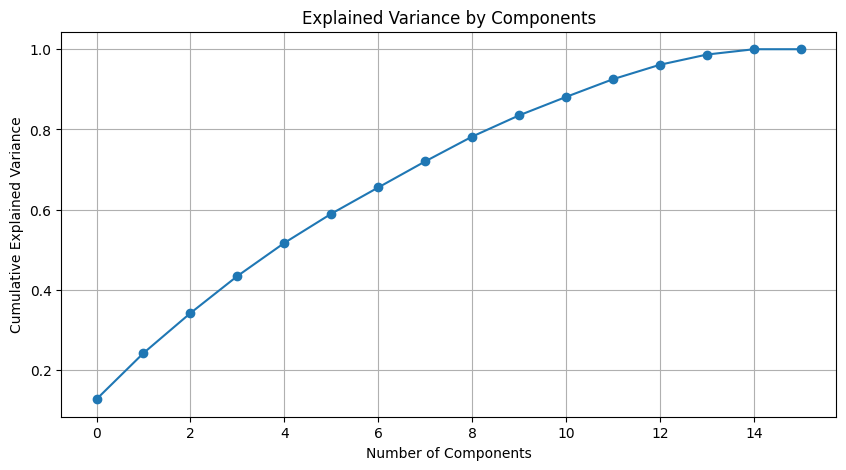

In [110]:
pca = PCA().fit(train)
explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 5))
plt.plot(explained_var_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


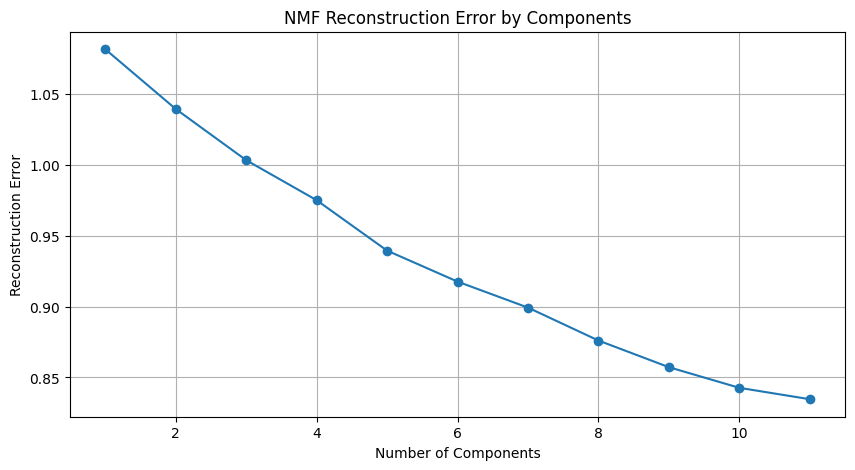

In [111]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

errors = []
n_components_options = range(1, 12) 

for n_components in n_components_options:
    nmf = NMF(n_components=n_components, init='random', random_state=0)
    W = nmf.fit_transform(train_minmax)
    H = nmf.components_
    reconstruction = np.dot(W, H)
    error = mean_squared_error(train, reconstruction)
    errors.append(error)

plt.figure(figsize=(10, 5))
plt.plot(n_components_options, errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('NMF Reconstruction Error by Components')
plt.grid(True)
plt.show()

In [112]:
perform_pca(train, 'books_pca', n_components=10)  # for PCA

In [113]:
perform_svd(train, 'books_svd')  # for SVD

In [114]:
perform_nmf(train_minmax, 'books_nmf', n_components=7)  # for NMF

In [115]:
books_nmf_embeddings = pd.read_csv('books_nmf_nmf_components2.csv')
books_pca_embeddings = pd.read_csv('books_pca_pca_components2.csv')
books_pca_info = pd.read_csv('books_pca_pca_info2.csv')
books_svd_embeddings_S = pd.read_csv('books_svd_svd_S2.csv')
books_svd_embeddings_U = pd.read_csv('books_svd_svd_U2.csv')
books_svd_embeddings_V = pd.read_csv('books_svd_svd_V2.csv')

In [116]:
print(books_pca_embeddings.shape)
print(books_pca_info.shape)
print(books_nmf_embeddings.shape)
print(books_svd_embeddings_S.shape)
print(books_svd_embeddings_U.shape)
print(books_svd_embeddings_V.shape)

(51754, 10)
(10, 2)
(51754, 7)
(6, 1)
(51754, 6)
(16, 6)


In [117]:
pca_km_models, pca_km_sils, pca_km_labels, pca_km_cluster_sils, pca_km_inertias = {}, {}, {}, {}, {}

for x in range(2, 11):
    model = KMeans(n_clusters=x, init='random', n_init='auto', random_state=42)
    model.fit(books_pca_embeddings)
    pca_km_models[x] = model
    pca_km_labels[x] = model.labels_
    pca_km_sils[x] = silhouette_score(books_pca_embeddings, model.labels_, metric='cosine')
    pca_km_cluster_sils[x] = silhouette_samples(books_pca_embeddings, model.labels_, metric='cosine')
    pca_km_inertias[x] = model.inertia_
    print(f'PCA Model M_{x} finished')

PCA Model M_2 finished
PCA Model M_3 finished
PCA Model M_4 finished
PCA Model M_5 finished
PCA Model M_6 finished
PCA Model M_7 finished
PCA Model M_8 finished
PCA Model M_9 finished
PCA Model M_10 finished


In [119]:
svd_km_models, svd_km_sils, svd_km_labels, svd_km_cluster_sils, svd_km_inertias = {}, {}, {}, {}, {}

for x in range(2, 11):
    model = KMeans(n_clusters=x, init='random', n_init='auto', random_state=42)
    model.fit(books_svd_embeddings_U)
    svd_km_models[x] = model
    svd_km_labels[x] = model.labels_
    svd_km_sils[x] = silhouette_score(books_svd_embeddings_U, model.labels_, metric='cosine')
    svd_km_cluster_sils[x] = silhouette_samples(books_svd_embeddings_U, model.labels_, metric='cosine')
    svd_km_inertias[x] = model.inertia_
    print(f'SVD Model M_{x} finished')

SVD Model M_2 finished
SVD Model M_3 finished
SVD Model M_4 finished
SVD Model M_5 finished
SVD Model M_6 finished
SVD Model M_7 finished
SVD Model M_8 finished
SVD Model M_9 finished
SVD Model M_10 finished


In [120]:
nmf_km_models, nmf_km_sils, nmf_km_labels, nmf_km_cluster_sils, nmf_km_inertias = {}, {}, {}, {}, {}

for x in range(2, 11):
    model = KMeans(n_clusters=x, init='random', n_init='auto', random_state=42)
    model.fit(books_nmf_embeddings)
    nmf_km_models[x] = model
    nmf_km_labels[x] = model.labels_
    nmf_km_sils[x] = silhouette_score(books_nmf_embeddings, model.labels_, metric='cosine')
    nmf_km_cluster_sils[x] = silhouette_samples(books_nmf_embeddings, model.labels_, metric='cosine')
    nmf_km_inertias[x] = model.inertia_
    print(f'NMF Model M_{x} finished')

NMF Model M_2 finished
NMF Model M_3 finished
NMF Model M_4 finished
NMF Model M_5 finished
NMF Model M_6 finished
NMF Model M_7 finished
NMF Model M_8 finished
NMF Model M_9 finished
NMF Model M_10 finished


In [122]:
kmeans_inertias_pca = pd.DataFrame({'k': [x for x in range(2, 11)], 'inertia': [y for x, y in pca_km_inertias.items()]})
kmeans_inertias_pca

,k,inertia
0,2,609266.570365
1,3,543299.377265
2,4,488168.009433
3,5,441658.813501
4,6,389942.402992
5,7,345391.803764
6,8,290912.705456
7,9,246516.299169
8,10,232280.140064


In [124]:
kmeans_inertias_svd = pd.DataFrame({'k': [x for x in range(2, 11)], 'inertia': [y for x, y in svd_km_inertias.items()]})
kmeans_inertias_svd

,k,inertia
0,2,5.194110
1,3,4.448727
2,4,3.795553
3,5,3.269866
4,6,2.778950
5,7,2.254282
6,8,2.073815
7,9,1.903285
8,10,1.816713


In [125]:
kmeans_inertias_nmf = pd.DataFrame({'k': [x for x in range(2, 11)], 'inertia': [y for x, y in nmf_km_inertias.items()]})
kmeans_inertias_nmf

,k,inertia
0,2,38618.616696
1,3,18301.973835
2,4,15014.805977
3,5,12298.349212
4,6,10157.371512
5,7,8814.998018
6,8,7705.408393
7,9,7211.613131
8,10,6843.117084


In [129]:
kmeans_labels_pca = pd.DataFrame(pca_km_labels)
kmeans_labels_pca

,2,3,4,5,6,7,8,9,10
0,0,1,2,3,4,0,2,2,0
1,0,1,2,3,4,1,2,1,4
2,0,1,2,3,4,0,2,2,4
3,1,0,0,4,1,2,4,5,7
4,1,0,0,4,1,2,4,5,7
...,...,...,...,...,...,...,...,...,...
51749,0,1,2,3,4,1,2,1,3
51750,0,1,2,3,4,0,2,2,0
51751,1,0,1,1,3,3,1,6,9
51752,1,0,1,1,3,3,1,6,9


In [130]:
kmeans_labels_svd = pd.DataFrame(svd_km_labels)
kmeans_labels_svd

,2,3,4,5,6,7,8,9,10
0,1,1,2,2,2,5,0,0,0
1,1,0,2,2,1,2,2,3,5
2,1,2,3,0,2,5,0,0,5
3,0,1,0,1,2,5,0,7,8
4,0,1,0,1,5,6,6,7,4
...,...,...,...,...,...,...,...,...,...
51749,1,0,2,2,1,2,2,3,9
51750,1,1,2,2,2,5,0,0,0
51751,0,0,0,4,5,1,1,1,2
51752,0,0,0,4,5,1,1,1,2


In [131]:
kmeans_labels_nmf = pd.DataFrame(nmf_km_labels)
kmeans_labels_nmf

,2,3,4,5,6,7,8,9,10
0,0,0,2,0,1,0,3,2,2
1,0,1,3,2,5,6,7,0,7
2,0,0,2,0,1,0,3,2,2
3,0,0,2,0,1,0,3,2,9
4,1,2,1,4,4,5,6,1,6
...,...,...,...,...,...,...,...,...,...
51749,0,1,3,2,5,6,7,0,7
51750,0,0,2,0,1,0,3,2,2
51751,0,0,2,0,1,0,0,6,0
51752,0,0,2,0,1,0,3,2,2


In [132]:
kmeans_inertias_pca.to_csv('books_pca_kmeans_inertias.csv')

In [133]:
kmeans_inertias_svd.to_csv('books_svd_kmeans_inertias.csv')

In [134]:
kmeans_inertias_nmf.to_csv('books_nmf_kmeans_inertias.csv')

In [135]:
kmeans_labels_pca.to_csv('books_pca_kmeans_labels.csv')

In [136]:
kmeans_labels_svd.to_csv('books_svd_kmeans_labels.csv')

In [137]:
kmeans_labels_nmf.to_csv('books_nmf_kmeans_labels.csv')